# Model Training


## Introduction: what is EfficientNet?

EfficientNet, first introduced in [Tan and Le, 2019](https://arxiv.org/abs/1905.11946) is among the most efficient models (i.e. requiring least FLOPS for inference) that reaches State-of-the-Art accuracy on both imagenet and common image classification transfer learning tasks.

The smallest base model is similar to [MnasNet](https://arxiv.org/abs/1807.11626), which reached near-SOTA with a significantly smaller model. By introducing a heuristic way to scale the model, EfficientNet provides a family of models (B0 to B7) that represents a good combination of efficiency and accuracy on a variety of scales. Such a scaling heuristics (compound-scaling, details see [Tan and Le, 2019](https://arxiv.org/abs/1905.11946)) allows the
efficiency-oriented base model (B0) to surpass models at every scale, while avoiding extensive grid-search of hyperparameters.


## Setup and data loading

In [1]:
!pip install -q keras-cv==0.9.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 30.3 MB/s eta 0:00:00


In [2]:
!pip install -q keras==3.5.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.1 MB/s eta 0:00:00


In [3]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

In [4]:
# Import numpy, matplotlib, seaborn, and other necessary libraries
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import tensorflow for [`tf.data`](https://www.tensorflow.org/api_docs/python/tf/data)
import tensorflow as tf
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

# Import keras and its modules
import keras_cv

import keras
from keras import ops
from keras import layers
from keras.applications import EfficientNetB0
from keras import optimizers
from keras.optimizers import schedules
from keras import losses
from keras.metrics import BinaryAccuracy, Precision, Recall, AUC
from keras.saving import register_keras_serializable

# Set the seeds for reproducibility
SEEDS = 42
keras.utils.set_random_seed(SEEDS)

### Define Some Hyperparameters

First, let's define the hyperparameters. We will use a batch size of 32 and train for 10 epochs. The image size is set to 224x224.

In [5]:
# Set the batch size, image size, and number of epochs
BATCH_SIZE = 32
IMAGE_SIZE = (224, 224)
EPOCHS = 10

### Gather Malaria Dataset

Here we load data from [tensorflow_datasets](https://www.tensorflow.org/datasets). Malaria dataset is provided in TFDS as [malaria](https://www.tensorflow.org/datasets/catalog/malaria). It features 27,558 images that belong to 2 classes: parasitized and uninfected.

In [6]:
# Set the dataset name
dataset_name = "malaria"

# Load the dataset and split it into train, test, and validation sets
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    dataset_name,
    split=["train[:70%]", "train[70%:85%]", "train[85%:]"],
    with_info=True,
    as_supervised=True,
)

# Get the number of classes in the dataset
NUM_CLASSES = ds_info.features["label"].num_classes


def package_inputs(image, label):
    """
    Packages the input image and label into a dictionary.

    Args:
        - image: The input image.
        - label: The corresponding label.

    Returns:
        A dictionary containing the input image and label.
    """
    return {"images": image, "labels": tf.one_hot(label, NUM_CLASSES)}


# Map the `package_inputs` function to the train and test sets and the evaluation set
train_ds = train_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = val_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(package_inputs, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle the training dataset
train_ds = train_ds.shuffle(BATCH_SIZE * 16)

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


### Visualise the dataset

The following code shows the images from the training set.

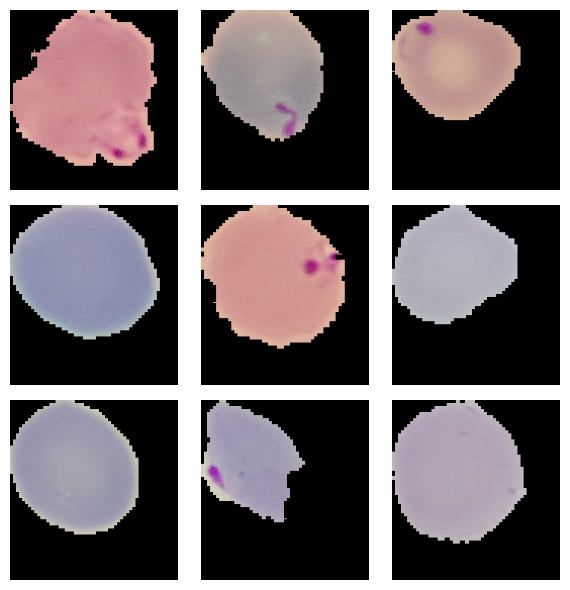

In [8]:
# Applying raggad batching to the train and test sets and the evaluation set
train_ds = train_ds.ragged_batch(BATCH_SIZE)
eval_ds = eval_ds.ragged_batch(BATCH_SIZE)
test_ds = test_ds.ragged_batch(BATCH_SIZE)

# Image batch for visualization from the train set
batch = next(iter(train_ds.take(1)))
image_batch = batch["images"]

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

### Data Augmentation

We can use the keras cv layers to perform data augmentation. In this notebook, we apply various augmentation techniques such as random flipping, rotation, translation, and contrast/brightness adjustment to the input images. These techniques help in increasing the diversity of the training data and improve the model's ability to generalize to unseen examples.

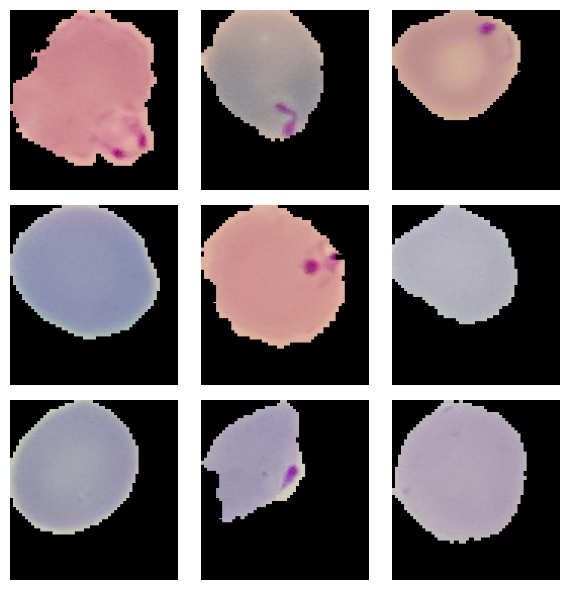

In [9]:
# Randomly flip the images in the batch
random_flip = keras_cv.layers.RandomFlip()
augmenters = [random_flip]

# Apply the augmenters to the image batch
image_batch = random_flip(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

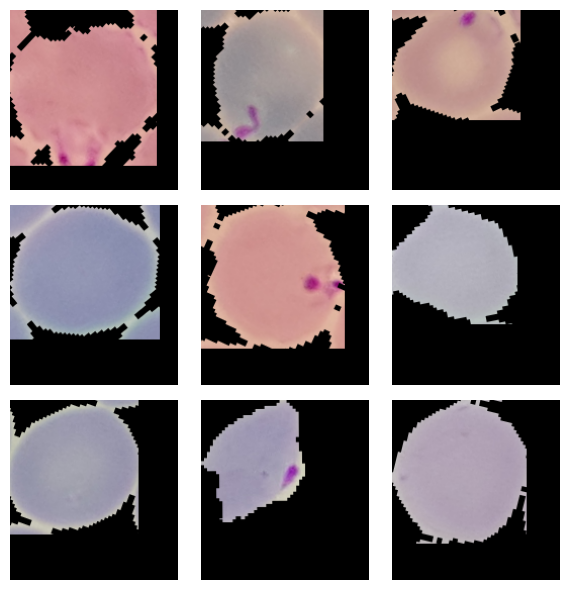

In [10]:
# Randomly rotate the images in the batch
random_rotation = keras_cv.layers.RandomRotation(factor=0.15)
augmenters += [random_rotation]

# Apply the augmenters to the image batch
image_batch = random_rotation(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

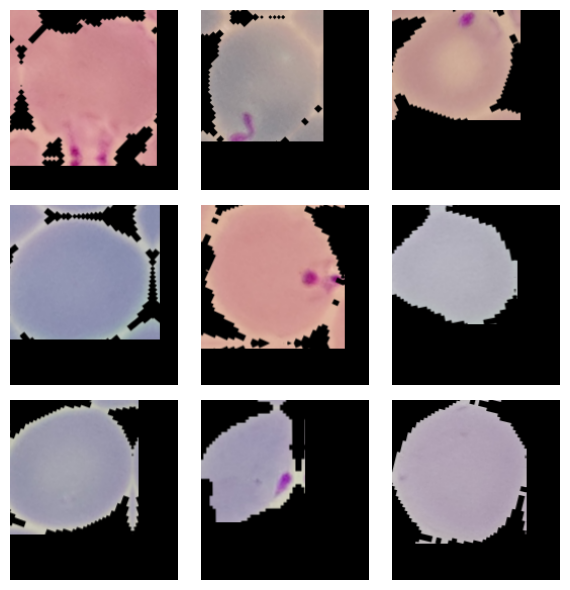

In [11]:
# Randomly translate the images in the batch
random_translation = keras_cv.layers.RandomTranslation(
    height_factor=0.1, width_factor=0.1
)
augmenters += [random_translation]

# Apply the augmenters to the image batch
image_batch = random_translation(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

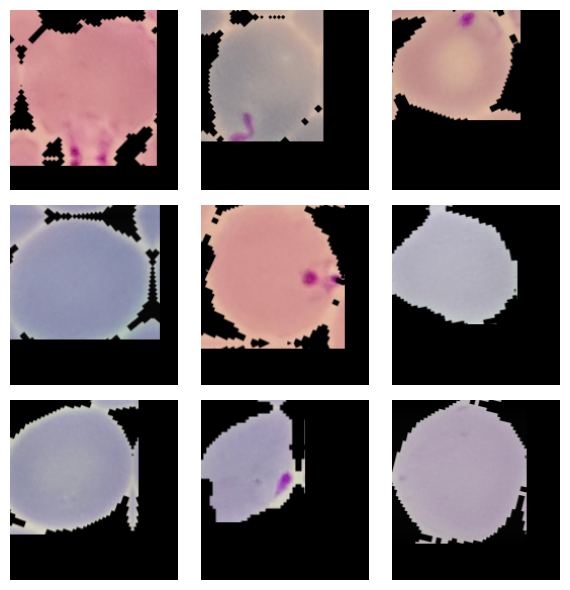

In [12]:
# Randomly change contrast of the images in the batch
random_contrast = keras_cv.layers.RandomContrast(factor=0.1, value_range=(0, 255))
augmenters += [random_contrast]

# Apply the augmenters to the image batch
image_batch = random_contrast(image_batch)

# Visualize the images in the batch
keras_cv.visualization.plot_image_gallery(
    image_batch.to_tensor(),
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [13]:
def create_augmenter_fn(augmenters):
    """
    Creates an augmenter function that applies a list of augmenters to the inputs.

    Args:
        augmenters (list): List of augmenter functions to be applied.

    Returns:
        augmenter_fn (function): Augmenter function that applies the augmenters to the inputs.
    """

    def augmenter_fn(inputs):
        """
        Apply a series of augmentations to the input data.

        Args:
            inputs: The input data to be augmented.

        Returns:
            The augmented data.
        """
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


# Apply all the previously defined augmenters to the train set
augmenter_fn = create_augmenter_fn(augmenters)
train_ds = train_ds.map(augmenter_fn, num_parallel_calls=tf.data.AUTOTUNE)

### Prepare Inputs

Once we verify the input data and augmentation are working correctly, we prepare the dataset for training. The input data is resized to a uniform size of 224x224.


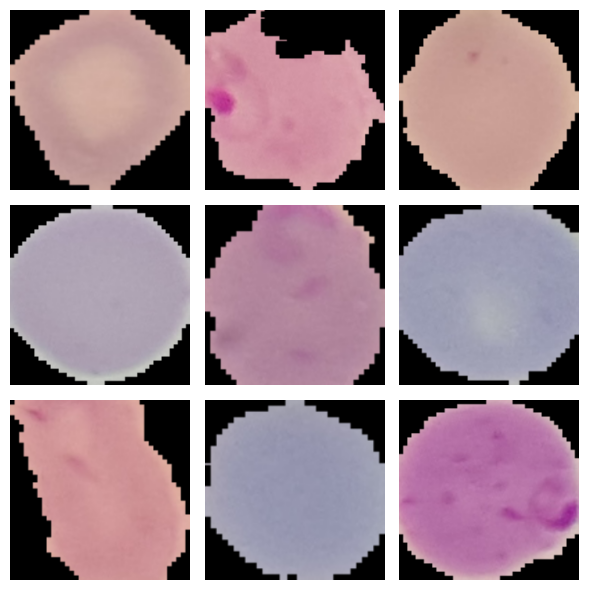

In [14]:
# Resizing the images in the train and test sets as well as the evaluation set
inference_resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], crop_to_aspect_ratio=True
)
train_ds = train_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

# Visualize the images in the batch
image_batch = next(iter(eval_ds.take(1)))["images"]
keras_cv.visualization.plot_image_gallery(
    image_batch,
    rows=3,
    cols=3,
    value_range=(0, 255),
    show=True,
)

In [15]:
def unpackage_dict(inputs):
    """
    Unpackages a dictionary and returns the values of the 'images' and 'labels' keys.

    Args:
        inputs (dict): A dictionary containing the 'images' and 'labels' keys.

    Returns:
        tuple: A tuple containing the values of the 'images' and 'labels' keys.
    """
    return inputs["images"], inputs["labels"]


# Unpackage the dictionaries in the train and test sets as well as the evaluation set
train_ds = train_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(unpackage_dict, num_parallel_calls=tf.data.AUTOTUNE)

## Optimizer Tuning

To achieve optimal performance, we need to use a learning rate schedule instead of a single learning rate. We will use Cosine decay with warmup schedule for this purpose. To know more, please refer to this [article](https://scorrea92.medium.com/cosine-learning-rate-decay-e8b50aa455b).

In [16]:
@register_keras_serializable()
def lr_warmup_cosine_decay(
    global_step, warmup_steps, hold=0, total_steps=0, start_lr=0.0, target_lr=1e-2
):
    """
    Applies a learning rate schedule that includes a warmup phase followed by a cosine decay.

    Args:
        - global_step (int): The current step in the training process.
        - warmup_steps (int): The number of steps to linearly increase the learning rate.
        - hold (int, optional): The number of steps to hold the learning rate at the target value before decaying. Defaults to 0.
        - total_steps (int, optional): The total number of training steps. Defaults to 0.
        - start_lr (float, optional): The initial learning rate at the start of warmup. Defaults to 0.0.
        - target_lr (float, optional): The target learning rate to reach after warmup and decay. Defaults to 1e-2.

    Returns:
        float: The calculated learning rate at the current global step.
    """
    # Cosine decay
    learning_rate = (
        0.5
        * target_lr
        * (
            1
            + ops.cos(
                math.pi
                * ops.convert_to_tensor(
                    global_step - warmup_steps - hold, dtype="float32"
                )
                / ops.convert_to_tensor(
                    total_steps - warmup_steps - hold, dtype="float32"
                )
            )
        )
    )

    warmup_lr = target_lr * (global_step / warmup_steps)

    if hold > 0:
        learning_rate = ops.where(
            global_step > warmup_steps + hold, learning_rate, target_lr
        )

    learning_rate = ops.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate


@register_keras_serializable()
class WarmUpCosineDecay(schedules.LearningRateSchedule):
    """
    A LearningRateSchedule that combines a warm-up phase with a cosine decay.

    Args:
        - warmup_steps (int): Number of steps to warm up the learning rate.
        - total_steps (int): Total number of steps for the learning rate schedule.
        - hold (int): Number of steps to hold the learning rate before decaying.
        - start_lr (float): Initial learning rate at the start of warm-up. Default is 0.0.
        - target_lr (float): Target learning rate at the end of warm-up. Default is 1e-2.

    Methods:
        __call__(step):
            Computes the learning rate at a given step.

        get_config():
            Returns the configuration of the learning rate schedule as a dictionary.

        from_config(config):
            Instantiates the learning rate schedule from a configuration dictionary.
    """

    def __init__(self, warmup_steps, total_steps, hold, start_lr=0.0, target_lr=1e-2):
        super().__init__()
        self.start_lr = start_lr
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.hold = hold

    def __call__(self, step):
        lr = lr_warmup_cosine_decay(
            global_step=step,
            total_steps=self.total_steps,
            warmup_steps=self.warmup_steps,
            start_lr=self.start_lr,
            target_lr=self.target_lr,
            hold=self.hold,
        )

        return ops.where(step > self.total_steps, 0.0, lr)

    def get_config(self):
        return {
            "start_lr": self.start_lr,
            "target_lr": self.target_lr,
            "warmup_steps": self.warmup_steps,
            "total_steps": self.total_steps,
            "hold": self.hold,
        }

    @classmethod
    def from_config(cls, config):

        return cls(**config)

### Define Optimizer and Loss

In this section, we define the optimizer and loss function for our model training.

We use the SGD optimizer with a learning rate schedule and a decay parameter. This optimizer is known for its ability to handle non-stationary objectives and adapt to changing conditions during training. The loss function we use is binary cross entropy. This loss function is commonly used for binary classification problems, where each sample belongs to one of two classes.

By defining the optimizer and loss function, we set the foundation for our model training process and ensure that the model is optimized to minimize the loss and improve its performance.

In [17]:
total_images = 27558
total_steps = (total_images // BATCH_SIZE) * EPOCHS
warmup_steps = int(0.1 * total_steps)
hold_steps = int(0.45 * total_steps)
schedule = WarmUpCosineDecay(
    start_lr=0.05,
    target_lr=1e-2,
    warmup_steps=warmup_steps,
    total_steps=total_steps,
    hold=hold_steps,
)

# Optimizer function for the model
optimizer_fn = optimizers.SGD(
    weight_decay=5e-4,
    learning_rate=schedule,
    momentum=0.9,
)

# Loss function for the model
loss_fn = losses.BinaryCrossentropy(label_smoothing=0.1)

## Set up Callbacks

We use callbacks to enhance the training process and monitor the model's performance. Here are the callbacks we use in this notebook:

- ModelCheckpoint: This callback saves the model weights after each epoch if the validation accuracy improves. It helps us keep track of the best model during training.

- EarlyStopping: This callback monitors the validation loss and stops the training if the loss does not improve after a certain number of epochs. It helps us prevent overfitting and saves training time.

- TensorBoard: This callback logs the training and validation loss to TensorBoard, which allows us to visualize and analyze the training process.

By using these callbacks, we can optimize the training process and improve the performance of our model.

In [18]:
# Callbacks for the training process
train_callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="model.keras",
        monitor="val_accuracy",
        save_best_only=True,
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=2, restore_best_weights=True
    ),
    keras.callbacks.TensorBoard(log_dir="./logs"),
]

## Transfer Learning from Pre-trained Weights

We use transfer learning to initialize the model weights with pre-trained weights. By using pre-trained weights, we can leverage the knowledge gained from training on a large dataset to solve our own problem. This allows us to train a model with less data and less time, while still being able to achieve good performance.

In [22]:
def build_model(num_classes):
    """
    Build a model for malaria diagnosis using EfficientNet.

    Args:
        num_classes (int): The number of classes for classification.

    Returns:
        keras.Model: The compiled model.
    """
    # Create the base model from the pre-trained model EfficientNet
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top of pretrained model
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="sigmoid", name="pred")(x)

    # Compile the model
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = optimizer_fn
    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[
            BinaryAccuracy(name="accuracy"),
            Precision(name="precision"),
            Recall(name="recall"),
            AUC(name="auc"),
        ],
    )
    return model

In [23]:
# Model summary
model = build_model(NUM_CLASSES)
model.summary()

Model: "EfficientNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,062,376 (15.50 MB)

 Trainable params: 5,122 (20.01 KB)

 Non-trainable params: 4,052,131 (15.46 MB)

 Optimizer params: 5,123 (20.01 KB)

### Train the Model

In [24]:
# Model training
history = model.fit(
    train_ds, epochs=EPOCHS, callbacks=train_callbacks, validation_data=eval_ds
)

Epoch 1/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 169s 268ms/step - accuracy: 0.7414 - auc: 0.8091 - loss: 0.5828 - precision: 0.7408 - recall: 0.7431 - val_accuracy: 0.9377 - val_auc: 0.9806 - val_loss: 0.3302 - val_precision: 0.9374 - val_recall: 0.9381
Epoch 2/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 139s 222ms/step - accuracy: 0.9145 - auc: 0.9651 - loss: 0.3636 - precision: 0.9155 - recall: 0.9133 - val_accuracy: 0.9407 - val_auc: 0.9831 - val_loss: 0.3333 - val_precision: 0.9414 - val_recall: 0.9400
Epoch 3/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 153s 252ms/step - accuracy: 0.9110 - auc: 0.9638 - loss: 0.3694 - precision: 0.9108 - recall: 0.9112 - val_accuracy: 0.9406 - val_auc: 0.9790 - val_loss: 0.3273 - val_precision: 0.9407 - val_recall: 0.9405
Epoch 4/10
603/603 ━━━━━━━━━━━━━━━━━━━━ 137s 226ms/step - accuracy: 0.9089 - auc: 0.9647 - loss: 0.3665 - precision: 0.9088 - recall: 0.9091 - val_accuracy: 0.9423 - val_auc: 0.9830 - val_loss: 0.3280 - val_precision: 0.9424 - val_recall: 0.9422
Epoch 5/10
603/6

### Plot the Training and Validation Metrics

Plot the training and validation accuracy/loss curves of the model. We can use these plots to check if the model has overfitted or underfitted the training data.

dict_keys(['accuracy', 'auc', 'loss', 'precision', 'recall', 'val_accuracy', 'val_auc', 'val_loss', 'val_precision', 'val_recall'])


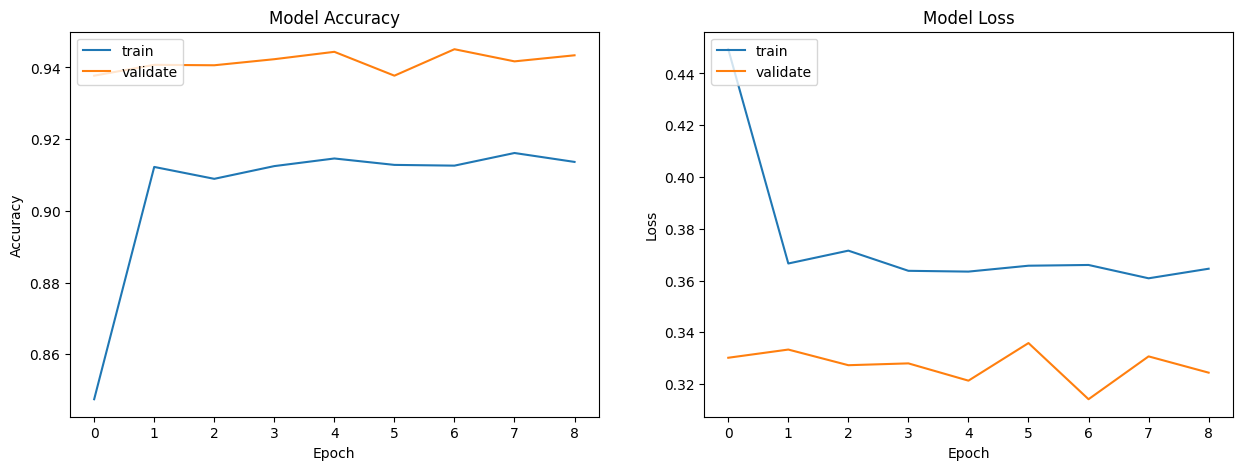

In [25]:
def plotmodelhistory(history):
    """
    Plots the model accuracy and loss for the training and validation sets.

    Args:
        history (keras.callbacks.History): The history object returned by the model.fit() function.

    Returns: None
    """
    # Plotting the model accuracy and loss for the training and validation sets
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # summarize history for accuracy
    axs[0].plot(history.history["accuracy"])
    axs[0].plot(history.history["val_accuracy"])
    axs[0].set_title("Model Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].set_xlabel("Epoch")
    axs[0].legend(["train", "validate"], loc="upper left")

    # summarize history for loss
    axs[1].plot(history.history["loss"])
    axs[1].plot(history.history["val_loss"])
    axs[1].set_title("Model Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(["train", "validate"], loc="upper left")
    plt.show()


# list all data in history
print(history.history.keys())

plotmodelhistory(history)

### Evaluate the Model

In [26]:
# Evaluate the model on the test set
accuracy = model.evaluate(test_ds)[1] * 100
print("Accuracy: {:.2f}%".format(accuracy))

130/130 ━━━━━━━━━━━━━━━━━━━━ 14s 92ms/step - accuracy: 0.9404 - auc: 0.9771 - loss: 0.3336 - precision: 0.9404 - recall: 0.9404
Accuracy: 94.10%


## Conclusion

- Model accuracy of EfficentNetB0 after evaluation is 94.10%.